In [22]:
import numpy as np
import surprise
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
data = pd.read_csv(
    "../0-Data/ratings.txt", sep=" ", names=["id_user", "id_movie", "rating"]
)

data.head()

,id_user,id_movie,rating
0,1,1,2.0
1,1,2,4.0
2,1,3,3.5
3,1,4,3.0
4,1,5,4.0


In [24]:
movies = len(data["id_movie"].unique())
users = len(data["id_user"].unique())
length = data.shape[0]
print("Total movies: ", movies)
print("Total users: ", users)
print("Total length: ", length)

Total movies:  2071
Total users:  1508
Total length:  35497


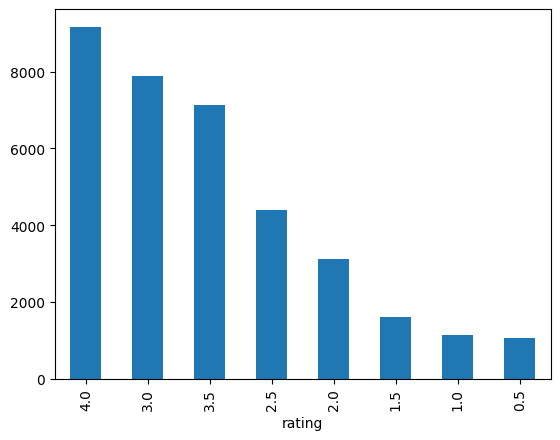

In [25]:
data["rating"].value_counts().plot(kind="bar")
plt.show()

In [26]:
min_rating = data["rating"].min()
max_rating = data["rating"].max()
print(f"Variance rating: {min_rating} a {max_rating}")

reader = surprise.Reader(rating_scale=(min_rating, max_rating))
data_surprise = surprise.Dataset.load_from_df(data, reader)

Variance rating: 0.5 a 4.0


In [27]:
data_full = data_surprise.build_full_trainset()
algorithm = surprise.SVDpp(n_factors=20)
algorithm.fit(data_full)

In [28]:
data_missing = data_full.build_anti_testset()
predicts = algorithm.test(data_missing)

In [29]:
predicts[:5]

[Prediction(uid=1, iid=13, r_ui=3.0028030537791928, est=3.433586390990881, details={'was_impossible': False}),
 Prediction(uid=1, iid=14, r_ui=3.0028030537791928, est=2.9470927408663266, details={'was_impossible': False}),
 Prediction(uid=1, iid=15, r_ui=3.0028030537791928, est=3.0904604211415965, details={'was_impossible': False}),
 Prediction(uid=1, iid=16, r_ui=3.0028030537791928, est=3.407908035425647, details={'was_impossible': False}),
 Prediction(uid=1, iid=17, r_ui=3.0028030537791928, est=3.100466901733608, details={'was_impossible': False})]

In [30]:
len(predicts)

3087574

In [31]:
from collections import defaultdict


def get_top_n(predicts, n=5):
    top_n = defaultdict(list)
    for user, movie, _, predict, _ in predicts:
        top_n[user].append((movie, predict))
    for user, predict_user in top_n.items():
        predict_user.sort(key=lambda x: x[1], reverse=True)
        top_n[user] = predict_user[:n]
    return top_n

In [33]:
top_5 = get_top_n(predicts, 5)
top_5

defaultdict(list,
            {1: [(286, 3.9713763416619394),
              (335, 3.9523131965203753),
              (805, 3.939188916592845),
              (293, 3.8815183223481533),
              (675, 3.8707368100067305)],
             2: [(286, 3.560277359690283),
              (805, 3.517880313347392),
              (335, 3.514398010195235),
              (400, 3.4641611457071195),
              (675, 3.4277061369288817)],
             3: [(205, 4.0),
              (216, 4.0),
              (512, 4.0),
              (696, 4.0),
              (1595, 3.947829795598367)],
             4: [(675, 3.3149828274896826),
              (335, 3.2863152139065606),
              (286, 3.2861403680283496),
              (307, 3.279114414260431),
              (805, 3.265949016831756)],
             5: [(286, 3.8271816905169955),
              (318, 3.815372335073811),
              (363, 3.7760248466063313),
              (307, 3.7733181448393465),
              (805, 3.711291709710892)],
     

In [34]:
predict_user = algorithm.predict(uid=30, iid=87)
rating = predict_user.est
print(rating)

2.4910647916236206


In [36]:
from surprise.model_selection import train_test_split

data_train, data_test = train_test_split(data_surprise, test_size=0.3)

algorithm = surprise.SVDpp(n_factors=20)
algorithm.fit(data_train)
geral_predicts = algorithm.test(data_test)
geral_predicts

[Prediction(uid=114, iid=235, r_ui=4.0, est=2.555502896427021, details={'was_impossible': False}),
 Prediction(uid=1443, iid=239, r_ui=4.0, est=3.6798927079349273, details={'was_impossible': False}),
 Prediction(uid=167, iid=211, r_ui=3.5, est=3.4561205898700624, details={'was_impossible': False}),
 Prediction(uid=86, iid=215, r_ui=4.0, est=4.0, details={'was_impossible': False}),
 Prediction(uid=984, iid=254, r_ui=3.0, est=2.4219996684060314, details={'was_impossible': False}),
 Prediction(uid=1062, iid=254, r_ui=4.0, est=3.145613920673791, details={'was_impossible': False}),
 Prediction(uid=1080, iid=246, r_ui=4.0, est=2.8786752372715196, details={'was_impossible': False}),
 Prediction(uid=1002, iid=8, r_ui=0.5, est=2.3084937154678076, details={'was_impossible': False}),
 Prediction(uid=1498, iid=245, r_ui=3.5, est=2.776717210975967, details={'was_impossible': False}),
 Prediction(uid=741, iid=12, r_ui=3.0, est=2.8367139185620798, details={'was_impossible': False}),
 Prediction(uid=8

In [37]:
from surprise import accuracy

accuracy.rmse(geral_predicts)

RMSE: 0.8007


0.8007121393205967

In [39]:
param = {"lr_all": [0.07, 0.01, 0.05], "reg_all": [0.02, 0.1, 1.0]}

surprise_grid = surprise.model_selection.GridSearchCV(
    surprise.SVDpp, param, measures=["rmse"], cv=3, n_jobs=-1
)
surprise_grid.fit(data_surprise)

print(surprise_grid.best_params["rmse"])

{'lr_all': 0.01, 'reg_all': 0.1}


In [46]:
from surprise import KNNBasic

data_full2 = data_surprise.build_full_trainset()

algorithm = KNNBasic(sim_options={"name": "cosine", "user_based": False})
algorithm.fit(data_full2)

neighbors = algorithm.get_neighbors(343, k=10)

print([movie for movie in neighbors])

Computing the cosine similarity matrix...
Done computing similarity matrix.
[58, 90, 102, 126, 147, 159, 168, 171, 193, 236]
